In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("Covid19Casos.csv")
df.head()

,id_evento_caso,sexo,edad,edad_años_meses,residencia_pais_nombre,residencia_provincia_nombre,residencia_departamento_nombre,carga_provincia_nombre,fecha_inicio_sintomas,fecha_apertura,...,fecha_fallecimiento,asistencia_respiratoria_mecanica,carga_provincia_id,origen_financiamiento,clasificacion,clasificacion_resumen,residencia_provincia_id,fecha_diagnostico,residencia_departamento_id,ultima_actualizacion
0,1000000,M,53.0,Años,Argentina,CABA,SIN ESPECIFICAR,Buenos Aires,NaN,2020-06-01,...,NaN,NO,6,Privado,Caso Descartado,Descartado,2,2020-06-09,0,2020-09-15
1,1000002,M,21.0,Años,Argentina,Buenos Aires,La Matanza,Buenos Aires,NaN,2020-06-01,...,NaN,NO,6,Público,Caso Descartado,Descartado,6,2020-06-01,427,2020-09-15
2,1000003,F,40.0,Años,Argentina,Córdoba,Capital,Córdoba,2020-05-24,2020-06-01,...,NaN,NO,14,Privado,Caso Descartado,Descartado,14,2020-06-01,14,2020-09-15
3,1000005,F,58.0,Años,Argentina,Mendoza,Las Heras,Mendoza,NaN,2020-06-01,...,NaN,NO,50,Público,Caso Descartado,Descartado,50,2020-06-01,49,2020-09-15
4,1000006,M,28.0,Años,Argentina,Buenos Aires,Malvinas Argentinas,Buenos Aires,2020-05-30,2020-06-01,...,NaN,NO,6,Público,Caso sospechoso - Con muestra sin resultado,Sospechoso,6,NaN,515,2020-09-15


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1594538 entries, 0 to 1594537
Data columns (total 25 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   id_evento_caso                    1594538 non-null  int64  
 1   sexo                              1594538 non-null  object 
 2   edad                              1592805 non-null  float64
 3   edad_años_meses                   1594538 non-null  object 
 4   residencia_pais_nombre            1594538 non-null  object 
 5   residencia_provincia_nombre       1594538 non-null  object 
 6   residencia_departamento_nombre    1594538 non-null  object 
 7   carga_provincia_nombre            1594538 non-null  object 
 8   fecha_inicio_sintomas             896957 non-null   object 
 9   fecha_apertura                    1594537 non-null  object 
 10  sepi_apertura                     1594538 non-null  int64  
 11  fecha_internacion                 148

In [3]:
mza = df.loc[df['residencia_provincia_nombre'] == 'Mendoza']

In [4]:
mza = mza[['sexo', 'edad', 'edad_años_meses', 'residencia_pais_nombre', 'residencia_provincia_nombre',
          'residencia_departamento_nombre', 'fecha_inicio_sintomas', 'fecha_apertura', 'sepi_apertura',
          'fecha_internacion', 'cuidado_intensivo', 'fecha_cui_intensivo',
          'fallecido', 'fecha_fallecimiento', 'asistencia_respiratoria_mecanica', 'clasificacion_resumen',
          'fecha_diagnostico']]

In [5]:
mza['clasificacion_resumen'].value_counts()

Descartado        20056
Confirmado        15756
Sospechoso         5553
Sin Clasificar        3
Name: clasificacion_resumen, dtype: int64

In [6]:
# convert months to a fraction of years

for i, AnioMes in enumerate(mza['edad_años_meses']):
    if AnioMes == 'Meses':
        mza['edad'].iloc[i] = mza['edad'].iloc[i] / 12       

/home/augusto/.local/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [7]:
mza.drop(['edad_años_meses'], axis=1, inplace=True)

In [8]:
mza_positivos = mza.loc[(mza['clasificacion_resumen'] == 'Confirmado')]

<AxesSubplot:ylabel='Frequency'>

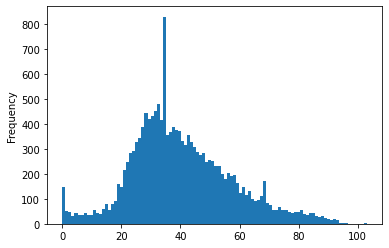

In [9]:
mza_positivos['edad'].plot(kind='hist', bins=100)

In [10]:
mza_positivos.dropna(subset=['edad'], inplace=True)
mza_positivos.isna().sum()

<ipython-input-10-bbdba0d9827e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mza_positivos.dropna(subset=['edad'], inplace=True)


sexo                                    0
edad                                    0
residencia_pais_nombre                  0
residencia_provincia_nombre             0
residencia_departamento_nombre          0
fecha_inicio_sintomas               11647
fecha_apertura                          0
sepi_apertura                           0
fecha_internacion                   14221
cuidado_intensivo                       0
fecha_cui_intensivo                 15639
fallecido                               0
fecha_fallecimiento                 15532
asistencia_respiratoria_mecanica        0
clasificacion_resumen                   0
fecha_diagnostico                     426
dtype: int64

<AxesSubplot:xlabel='count', ylabel='residencia_departamento_nombre'>

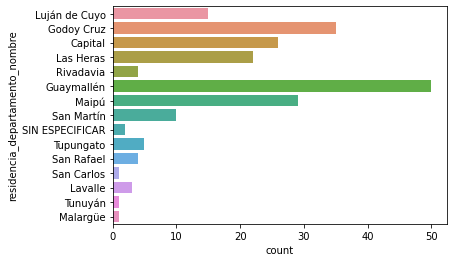

In [11]:
import seaborn as sns
sns.countplot(y='residencia_departamento_nombre', data=mza_positivos.loc[mza_positivos.fallecido == 'SI'])

In [12]:
mza_positivos.loc[mza_positivos.fallecido == 'SI'].\
    groupby('residencia_departamento_nombre').size().sort_values(ascending=False)

residencia_departamento_nombre
Guaymallén         50
Godoy Cruz         35
Maipú              29
Capital            26
Las Heras          22
Luján de Cuyo      15
San Martín         10
Tupungato           5
San Rafael          4
Rivadavia           4
Lavalle             3
SIN ESPECIFICAR     2
Tunuyán             1
San Carlos          1
Malargüe            1
dtype: int64

In [13]:
mza_fallecidos = mza_positivos[['fallecido', 'fecha_fallecimiento']]

In [14]:
mza_fallecidos.dropna(subset=['fecha_fallecimiento'], inplace=True)

<ipython-input-14-3cb1ae19b56d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mza_fallecidos.dropna(subset=['fecha_fallecimiento'], inplace=True)


In [15]:
mza_fallecidos['fallecido'] = mza_fallecidos['fallecido'].replace("NO", 0)
mza_fallecidos['fallecido'] = mza_fallecidos['fallecido'].replace("SI", 1)


<ipython-input-15-00b09c77f34c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mza_fallecidos['fallecido'] = mza_fallecidos['fallecido'].replace("NO", 0)
<ipython-input-15-00b09c77f34c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mza_fallecidos['fallecido'] = mza_fallecidos['fallecido'].replace("SI", 1)


<AxesSubplot:xlabel='fecha'>

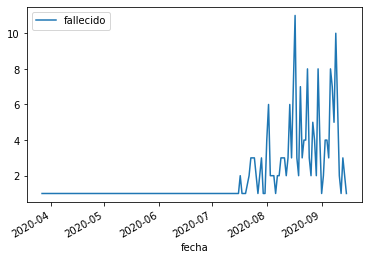

In [16]:
mza_fallecidos = mza_fallecidos.groupby('fecha_fallecimiento').sum()
mza_fallecidos.reset_index(inplace=True)
mza_fallecidos['fecha'] = pd.to_datetime(mza_fallecidos['fecha_fallecimiento'], format='%Y-%m-%d')
mza_fallecidos.plot(kind='line', x='fecha', y='fallecido')

In [17]:
df['fecha'] = pd.to_datetime(df['fecha_fallecimiento'], format='%Y-%m-%d')
df['fallecido'] = df['fallecido'].replace("SI", 1)
df['fallecido'] = df['fallecido'].replace("NO", 0)

In [18]:
fall_diarios = df[['fallecido', 'fecha_fallecimiento', 'fecha']].groupby('fecha_fallecimiento').sum()
fall_diarios.reset_index(inplace=True)
fall_diarios['fecha'] = pd.to_datetime(fall_diarios['fecha_fallecimiento'], format='%Y-%m-%d')

In [19]:
fall_diarios.head()

,fecha_fallecimiento,fallecido,fecha
0,2020-03-07,1,2020-03-07
1,2020-03-09,1,2020-03-09
2,2020-03-10,1,2020-03-10
3,2020-03-12,2,2020-03-12
4,2020-03-13,2,2020-03-13


<AxesSubplot:xlabel='fecha', ylabel='fallecido'>

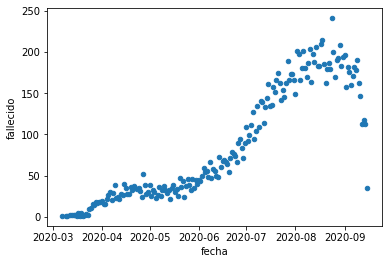

In [20]:
fall_diarios.plot(kind='scatter', x='fecha', y='fallecido')

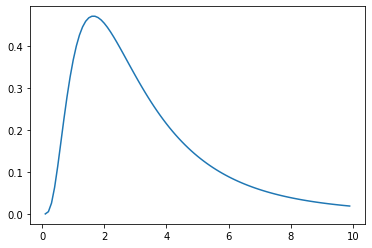

In [21]:
# Define fitting curve
import matplotlib.pyplot as plt

def log_normal(t, a, b, c):
    y = (a/t)*np.exp(-((np.log(t)-b)**2)/c**2)
    return y

time = np.arange(0.1,10, 0.1)
y = [log_normal(t, 1, 1, 1) for t in time]
plt.plot(time, y)

In [22]:
# convert dates to Date of Year format
fall_diarios['DoY'] = fall_diarios.fecha.apply(lambda x: x.strftime('%j'))
fall_diarios.head()

,fecha_fallecimiento,fallecido,fecha,DoY
0,2020-03-07,1,2020-03-07,067
1,2020-03-09,1,2020-03-09,069
2,2020-03-10,1,2020-03-10,070
3,2020-03-12,2,2020-03-12,072
4,2020-03-13,2,2020-03-13,073


In [23]:
fall_diarios.tail(14)

,fecha_fallecimiento,fallecido,fecha,DoY
177,2020-09-02,158,2020-09-02,246
178,2020-09-03,182,2020-09-03,247
179,2020-09-04,176,2020-09-04,248
180,2020-09-05,160,2020-09-05,249
181,2020-09-06,171,2020-09-06,250
182,2020-09-07,182,2020-09-07,251
183,2020-09-08,178,2020-09-08,252
184,2020-09-09,190,2020-09-09,253
185,2020-09-10,162,2020-09-10,254
186,2020-09-11,146,2020-09-11,255


In [24]:
# Delete two last entries (too few cases)
fall_diarios = fall_diarios[:-5][:]

In [25]:
# Cast column values and set first day as #1
fall_diarios['DoY'] = fall_diarios.DoY.astype(int)
fall_diarios['DoY'] = fall_diarios.DoY.apply(lambda x: x - 66)
fall_diarios.head()

,fecha_fallecimiento,fallecido,fecha,DoY
0,2020-03-07,1,2020-03-07,1
1,2020-03-09,1,2020-03-09,3
2,2020-03-10,1,2020-03-10,4
3,2020-03-12,2,2020-03-12,6
4,2020-03-13,2,2020-03-13,7


In [26]:
# Normalize values to estimate fitting correctly
x_data = fall_diarios.DoY
y_data = fall_diarios.fallecido
xdata =x_data/max(x_data)
ydata =y_data/max(y_data)

In [27]:
#Find best parameters which optimizes the curve
from scipy.optimize import curve_fit

popt, pcov = curve_fit(log_normal, xdata, ydata)
print(popt)

[0.98746087 0.30536689 0.69652833]


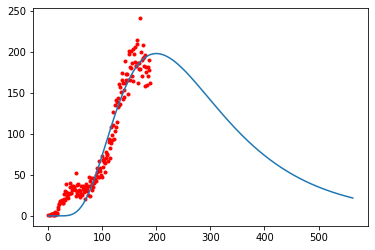

Max number of cases on day 266.22 with 197.96683037205125 deaths


In [28]:
xfit = np.arange(0.005, 3, 0.005)
yfit = [log_normal(x, *popt) for x in xfit]

# Convert to numpy array to multiply it by a constant
xfit = np.asarray(xfit)
yfit = np.asarray(yfit)

# Re-scale arrays
xdata = xdata * max(x_data)
xfit = xfit * max(x_data)
ydata = ydata * max(y_data)
yfit = yfit * max(y_data)

plt.plot(xdata, ydata, 'r.')
plt.plot(xfit, yfit)
plt.show()

maxNumCases = max(yfit)
dayMaxCases = xfit[np.where(yfit == maxNumCases)][0]
print("Max number of cases on day {} with {} deaths".format(dayMaxCases+66, maxNumCases))

In [29]:
fall_diarios.tail()

,fecha_fallecimiento,fallecido,fecha,DoY
181,2020-09-06,171,2020-09-06,184
182,2020-09-07,182,2020-09-07,185
183,2020-09-08,178,2020-09-08,186
184,2020-09-09,190,2020-09-09,187
185,2020-09-10,162,2020-09-10,188


In [30]:
max(fall_diarios.fallecido)

241

In [31]:
det = pd.read_csv('Covid19Determinaciones.csv')
det.head()

,fecha,provincia,codigo_indec_provincia,departamento,codigo_indec_departamento,localidad,codigo_indec_localidad,origen_financiamiento,tipo,ultima_actualizacion,total,positivos
0,2008-08-13,Jujuy,38,Dr. Manuel Belgrano,21,SAN SALVADOR DE JUJUY,60,Público,Provincial,2020-09-13,1,NaN
1,2019-07-13,CABA,2,COMUNA 02,2,RECOLETA,10,Público,Universitario público,2020-09-13,1,NaN
2,2020-02-11,CABA,2,COMUNA 04,4,PARQUE PATRICIOS,10,Público,Nacional,2020-09-13,2,NaN
3,2020-02-20,Buenos Aires,6,Bahía Blanca,56,BAHIA BLANCA,10,Privado,Privado,2020-09-13,1,NaN
4,2020-02-20,CABA,2,COMUNA 04,4,PARQUE PATRICIOS,10,Público,Nacional,2020-09-13,1,NaN


In [32]:
det_mza = det.loc[det.provincia == 'Mendoza']
det_mza.positivos.sum()

14404.0

<AxesSubplot:xlabel='positivos', ylabel='localidad'>

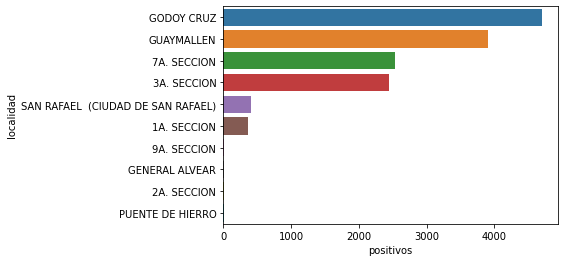

In [33]:
mza_pos_loc = det_mza.groupby('localidad').sum().sort_values('positivos', ascending=False)
mza_pos_loc.reset_index(inplace=True)
mza_pos_hist = mza_pos_loc[['localidad', 'positivos']].head(10)
#mza_pos_hist.head()
sns.barplot(y="localidad", x="positivos", data=mza_pos_hist)

In [34]:
mza_pos_loc[['localidad', 'positivos']]

,localidad,positivos
0,GODOY CRUZ,4705.0
1,GUAYMALLEN,3904.0
2,7A. SECCION,2530.0
3,3A. SECCION,2444.0
4,SAN RAFAEL (CIUDAD DE SAN RAFAEL),409.0
5,1A. SECCION,366.0
6,9A. SECCION,11.0
7,GENERAL ALVEAR,9.0
8,2A. SECCION,6.0
9,PUENTE DE HIERRO,3.0


In [35]:
det_bsas = det.loc[det.provincia == 'Buenos Aires']

In [36]:
det_bsas.groupby('localidad').sum().sort_values('positivos', ascending=False).head(20)

,codigo_indec_provincia,codigo_indec_departamento,codigo_indec_localidad,total,positivos
localidad,,,,,
LA PLATA,2448,179928,12240,67374,26527.0
VILLA SARMIENTO,1164,110192,1940,31984,13731.0
PABLO NOGUES,996,85490,9960,33639,13304.0
FLORENCIO VARELA,1230,56170,2050,29306,12041.0
BERNAL,804,88172,1340,15060,10336.0
MAR DEL PLATA,2370,141015,43450,27839,9659.0
BAHIA BLANCA,2442,22792,4070,20906,6707.0
HURLINGHAM,972,66096,1620,14342,6640.0
GENERAL SAN MARTÍN,1008,62328,1680,9089,5092.0


In [37]:
det_caba = det.loc[det.provincia == 'CABA']

In [38]:
det_caba.groupby('localidad').sum().sort_values('positivos', ascending=False).head(20)

,codigo_indec_provincia,codigo_indec_departamento,codigo_indec_localidad,total,positivos
localidad,,,,,
RECOLETA,1104,1104,5520,249550,101614.0
PARQUE PATRICIOS,1354,2708,6770,166460,62554.0
PALERMO,708,4956,3540,105175,43107.0
ALMAGRO,468,1170,2340,64615,21338.0
VILLA CRESPO,292,2190,1460,30752,12653.0
FLORES,584,2044,2920,26254,12074.0
CABALLITO,846,2538,4230,24900,9856.0
BARRACAS,634,1268,3170,29186,9155.0
BALVANERA,846,1269,4230,17392,6799.0


In [39]:
covidStats = pd.read_csv("2020-09-15_Nacional.csv", skiprows=3)
covidStats.head()

,fecha,fallecidos,terapia,casos_dx,diagnosticos,internados,casos_fis,casos_fis_ajustada,casos_fa
0,2020-01-01,0,0,0,2,1,0,0,0
1,2020-01-02,0,0,0,0,0,1,1,0
2,2020-01-03,0,0,0,0,0,0,0,0
3,2020-01-04,0,0,0,0,0,0,0,0
4,2020-01-05,0,0,0,0,0,0,0,0


In [40]:
covidStats['fecha'] = pd.to_datetime(covidStats['fecha'], format='%Y-%m-%d')

In [41]:
dead = covidStats.loc[covidStats.fallecidos > 0]
dead['DoY'] = [date.strftime('%j') for date in dead.fecha]
dead['DoY'] = dead.DoY.astype(int)

<ipython-input-41-7340839a20a7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dead['DoY'] = [date.strftime('%j') for date in dead.fecha]
<ipython-input-41-7340839a20a7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dead['DoY'] = dead.DoY.astype(int)


In [42]:
dead['DoS'] = [(i - 66) for i in dead.DoY]
dead.head()

<ipython-input-42-f43ac17c4f11>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dead['DoS'] = [(i - 66) for i in dead.DoY]


,fecha,fallecidos,terapia,casos_dx,diagnosticos,internados,casos_fis,casos_fis_ajustada,casos_fa,DoY,DoS
66,2020-03-07,1,0,1,8,5,4,4,6,67,1
72,2020-03-13,1,1,6,82,17,43,44,31,73,7
77,2020-03-18,1,5,29,189,38,79,83,47,78,12
80,2020-03-21,1,6,62,291,44,149,150,67,81,15
83,2020-03-24,3,6,106,388,43,103,110,111,84,18


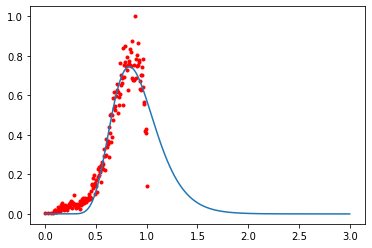

In [44]:
x_data = dead.DoS
y_data = dead.fallecidos
xdata =x_data/max(x_data)
ydata =y_data/max(y_data)

popt, pcov = curve_fit(log_normal, xdata, ydata)

xfit = np.arange(0.005, 3, 0.005)
yfit = [log_normal(x, *popt) for x in xfit]

plt.plot(xdata, ydata, 'r.')
plt.plot(xfit, yfit)
plt.show()

In [45]:
dead.tail(14)

,fecha,fallecidos,terapia,casos_dx,diagnosticos,internados,casos_fis,casos_fis_ajustada,casos_fa,DoY,DoS
245,2020-09-02,130,63,11221,21425,474,9871,7892,10600,246,180
246,2020-09-03,138,58,11062,22012,446,9756,9614,10685,247,181
247,2020-09-04,144,70,10677,21954,410,9744,10295,10815,248,182
248,2020-09-05,129,52,9092,19147,370,8596,10090,8060,249,183
249,2020-09-06,144,53,6100,12173,309,7049,9644,5978,250,184
250,2020-09-07,152,58,9919,19782,451,9471,9935,11059,251,185
251,2020-09-08,132,51,11952,22848,412,9038,7363,11872,252,186
252,2020-09-09,161,55,11950,24312,337,8199,5894,11159,253,187
253,2020-09-10,116,34,11069,23319,287,7434,6283,11065,254,188
254,2020-09-11,114,45,11468,23839,266,6524,3835,10266,255,189


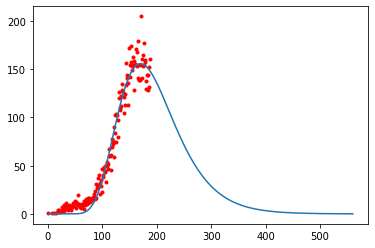

Max number of cases on day 236.17000000000002 with 155.8842083019037 deaths


In [46]:
x_data = dead.DoS[:-6]
y_data = dead.fallecidos[:-6]
xdata =x_data/max(x_data)
ydata =y_data/max(y_data)

popt, pcov = curve_fit(log_normal, xdata, ydata)

xfit = np.arange(0.005, 3, 0.005)
yfit = [log_normal(x, *popt) for x in xfit]

# Convert to numpy array to multiply it by a constant
xfit = np.asarray(xfit)
yfit = np.asarray(yfit)

# Re-scale arrays
xdata = xdata * max(x_data)
xfit = xfit * max(x_data)
ydata = ydata * max(y_data)
yfit = yfit * max(y_data)

plt.plot(xdata, ydata, 'r.')
plt.plot(xfit, yfit)
plt.show()

maxNumCases = max(yfit)
dayMaxCases = xfit[np.where(yfit == maxNumCases)][0]
print("Max number of cases on day {} with {} deaths".format(dayMaxCases+66, maxNumCases))